### Máster en Ciencia de Datos - CUNEF

### Trabajo Final de Máster

### Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación

Alba Rodríguez Berenguel

En este notebook se va a construir el modelo Regresión Logística. 

Se van a realizar distintas pruebas para ver qué funciona mejor. Primero se realizará un modelo con el dataset completo y después con las distintas técnicas de feature selection que se han aplicado, para comprobar si se puede disminuir el número de variables y no afecta a la predicción. Después se probarán distintas técnicas para dataset desbalanceados como SMOTE, RandomUndersampler y SMOTETomek. Los pasos que se van a seguir son los siguientes:

1. Importación de librerías, funciones y datos.
2. Modelo inicial
3. Modelos con Feature Selection
4. Modelos con técnicas para dataset desbalanceados
5. Exportación del mejor modelo

## 1. Importación de librerías, funciones y datos

In [1]:
# Import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model.
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion Matrix: \n{}\n'.format(confusion_matrix(y_test, pred)))

In [3]:
# Load data.
X_train = pd.read_parquet("../data/processed/X_train.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")['isfraud']

X_test = pd.read_parquet("../data/processed/X_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['isfraud']

X_train_boruta = pd.read_parquet("../data/processed/X_train_boruta.parquet")
X_test_boruta = pd.read_parquet("../data/processed/X_test_boruta.parquet")

X_train_rfe = pd.read_parquet("../data/processed/X_train_rfe.parquet")
X_test_rfe = pd.read_parquet("../data/processed/X_test_rfe.parquet")

X_train_lasso1 = pd.read_parquet("../data/processed/X_train_lasso1.parquet")
X_test_lasso1 = pd.read_parquet("../data/processed/X_test_lasso1.parquet")

X_train_lasso2 = pd.read_parquet("../data/processed/X_train_lasso2.parquet")
X_test_lasso2 = pd.read_parquet("../data/processed/X_test_lasso2.parquet")

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

## 2. Modelo inicial

In [5]:
# Classifier.
classifier = LogisticRegression(penalty='l2', random_state=12345, class_weight="balanced", solver='liblinear')

lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)   
])

In [6]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('catohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['productcd', 'card4',
                                                   'card6', 'm4']),
                                                 ('catbin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['m...
                                                                   SimpleImputer(fill_value=-99,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['transactionamt', 'c1', 'c3',
                                                   'c5', 'd1', 'd3', 'd4',
                                                   'd10', 'd11', 'd15', 'v3',
                                                   'v4', 'v6', 'v8', 'v11',
                                                   'v13', 'v17', 'v20', 'v23',
                                                   'v26', 'v27', 'v30', 'v36',
                                                   'v37', 'v40', 'v44', 'v47',
                                                   'v48', 'v54', 'v56', ...])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [7]:
# Predictions of target value for the validation set.
pred = lr.predict(X_test)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr.predict_proba(X_test)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8393682969378499
Accuracy of the model: 0.7860558579640841

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113837
           1       0.11      0.73      0.19      4105

    accuracy                           0.79    117942
   macro avg       0.55      0.76      0.53    117942
weighted avg       0.96      0.79      0.85    117942


Confusion Matrix: 
[[89715 24122]
 [ 1111  2994]]



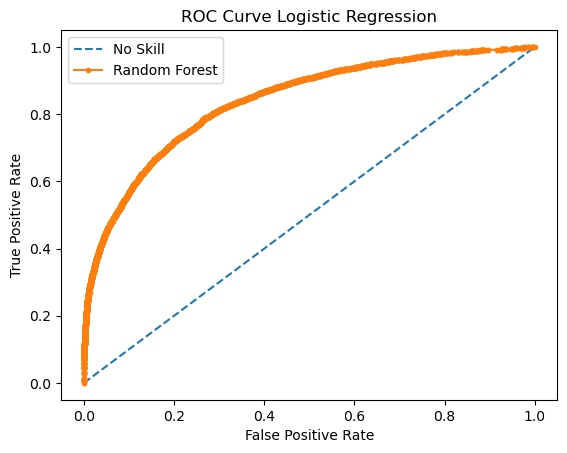

In [8]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

## 3. Modelo con Feature Selection

### 3.1. Boruta

In [9]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

lr_boruta = Pipeline([
    ('classifier', classifier)   
])

In [10]:
lr_boruta.fit(X_train_boruta, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [11]:
# Predictions of target value for the validation set.
pred = lr_boruta.predict(X_test_boruta)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_boruta.predict_proba(X_test_boruta)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8381548025529633
Accuracy of the model: 0.7864119652032355

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113837
           1       0.11      0.73      0.19      4105

    accuracy                           0.79    117942
   macro avg       0.55      0.76      0.53    117942
weighted avg       0.96      0.79      0.85    117942


Confusion Matrix: 
[[89759 24078]
 [ 1113  2992]]



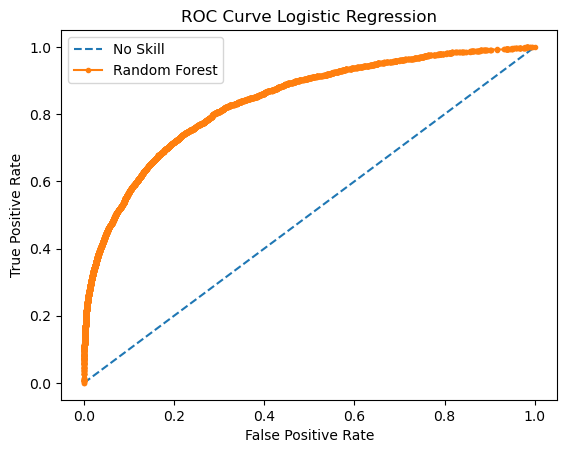

In [12]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

### 3.2. RFE

In [13]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

lr_rfe = Pipeline([
    ('classifier', classifier)   
])

In [14]:
lr_rfe.fit(X_train_rfe, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [15]:
# Predictions of target value for the validation set.
pred = lr_rfe.predict(X_test_rfe)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_rfe.predict_proba(X_test_rfe)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8189231847913149
Accuracy of the model: 0.7732614335859999

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    113837
           1       0.10      0.70      0.18      4105

    accuracy                           0.77    117942
   macro avg       0.54      0.74      0.52    117942
weighted avg       0.96      0.77      0.84    117942


Confusion Matrix: 
[[88310 25527]
 [ 1215  2890]]



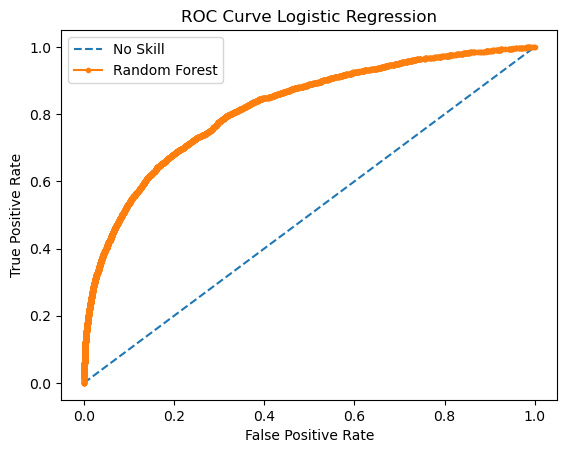

In [16]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

### 3.3. Lasso

#### Prueba 1

In [17]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

lr_lasso1 = Pipeline([
    ('classifier', classifier)   
])

In [18]:
lr_lasso1.fit(X_train_lasso1, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [19]:
# Predictions of target value for the validation set.
pred = lr_lasso1.predict(X_test_lasso1)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_lasso1.predict_proba(X_test_lasso1)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8390911393202263
Accuracy of the model: 0.785072323684523

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113837
           1       0.11      0.73      0.19      4105

    accuracy                           0.79    117942
   macro avg       0.55      0.76      0.53    117942
weighted avg       0.96      0.79      0.85    117942


Confusion Matrix: 
[[89606 24231]
 [ 1118  2987]]



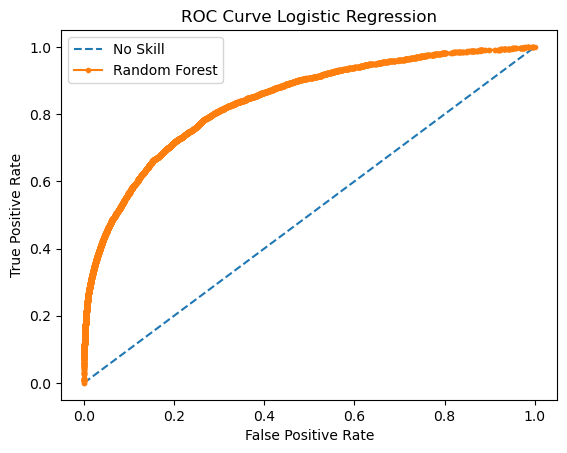

In [20]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

#### Prueba 2

In [21]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

lr_lasso2 = Pipeline([
    ('classifier', classifier)   
])

In [22]:
lr_lasso2.fit(X_train_lasso2, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [23]:
# Predictions of target value for the validation set.
pred = lr_lasso2.predict(X_test_lasso2)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_lasso2.predict_proba(X_test_lasso2)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8330543542625646
Accuracy of the model: 0.7850808024283122

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113837
           1       0.11      0.72      0.19      4105

    accuracy                           0.79    117942
   macro avg       0.55      0.75      0.53    117942
weighted avg       0.96      0.79      0.85    117942


Confusion Matrix: 
[[89641 24196]
 [ 1152  2953]]



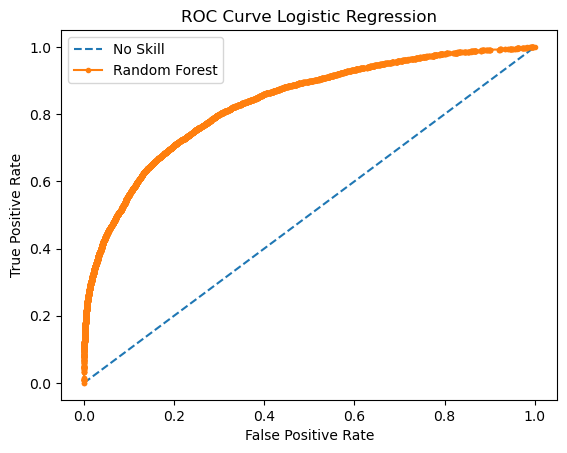

In [24]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

## 4. Modelos con técnicas para dataset desbalanceados

### 4.1. SMOTE

In [25]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')


lr_smote = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=12345)),
    ('classifier', classifier)
])

In [26]:
lr_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('catohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['productcd', 'card4',
                                                   'card6', 'm4']),
                                                 ('catbin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['m...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['transactionamt', 'c1', 'c3',
                                                   'c5', 'd1', 'd3', 'd4',
                                                   'd10', 'd11', 'd15', 'v3',
                                                   'v4', 'v6', 'v8', 'v11',
                                                   'v13', 'v17', 'v20', 'v23',
                                                   'v26', 'v27', 'v30', 'v36',
                                                   'v37', 'v40', 'v44', 'v47',
                                                   'v48', 'v54', 'v56', ...])])),
                ('smote', SMOTE(random_state=12345)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [27]:
# Predictions of target value for the validation set.
pred = lr_smote.predict(X_test)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_smote.predict_proba(X_test)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8385802029884879
Accuracy of the model: 0.791244849163148

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113837
           1       0.11      0.72      0.19      4105

    accuracy                           0.79    117942
   macro avg       0.55      0.76      0.54    117942
weighted avg       0.96      0.79      0.86    117942


Confusion Matrix: 
[[90362 23475]
 [ 1146  2959]]



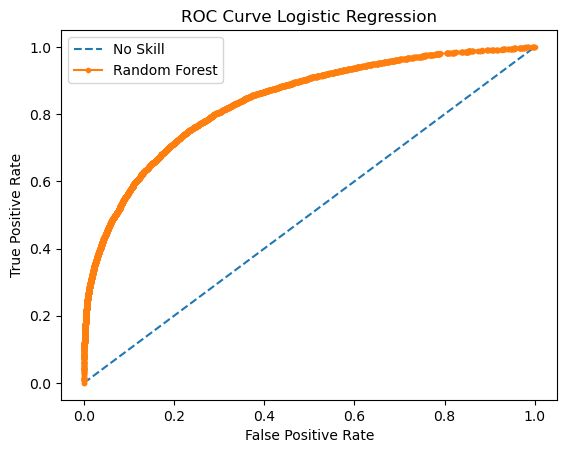

In [28]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

### 4.2. RandomUnderSampler

In [29]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')

lr_rus = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', rus),
    ('classifier', classifier)
])

In [30]:
lr_rus.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('catohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['productcd', 'card4',
                                                   'card6', 'm4']),
                                                 ('catbin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['m...
                                                                   StandardScaler())]),
                                                  ['transactionamt', 'c1', 'c3',
                                                   'c5', 'd1', 'd3', 'd4',
                                                   'd10', 'd11', 'd15', 'v3',
                                                   'v4', 'v6', 'v8', 'v11',
                                                   'v13', 'v17', 'v20', 'v23',
                                                   'v26', 'v27', 'v30', 'v36',
                                                   'v37', 'v40', 'v44', 'v47',
                                                   'v48', 'v54', 'v56', ...])])),
                ('smote', RandomUnderSampler(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [31]:
# Predictions of target value for the validation set.
pred = lr_rus.predict(X_test)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_rus.predict_proba(X_test)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.821497524020311
Accuracy of the model: 0.7396177782299774

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.74      0.85    113837
           1       0.09      0.74      0.17      4105

    accuracy                           0.74    117942
   macro avg       0.54      0.74      0.51    117942
weighted avg       0.96      0.74      0.82    117942


Confusion Matrix: 
[[84192 29645]
 [ 1065  3040]]



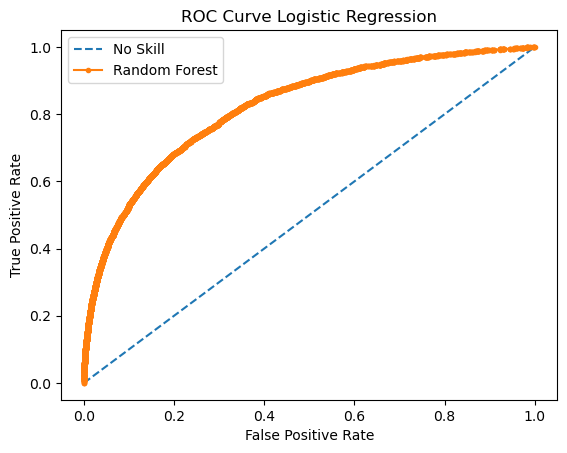

In [32]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()

### 4.3.SMOTETomek

In [33]:
# Classifier.
classifier = LogisticRegression(penalty='l2',random_state=12345,class_weight="balanced", solver='liblinear')

smt = SMOTETomek(random_state=42, sampling_strategy=0.4)

lr_smt = Pipeline([
    ('smote', smt),
    ('classifier', classifier)
])

In [34]:
lr_smt.fit(X_train_rfe, y_train)

Pipeline(steps=[('smote', SMOTETomek(random_state=42, sampling_strategy=0.4)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=12345,
                                    solver='liblinear'))])

In [35]:
# Predictions of target value for the validation set.
pred = lr_smt.predict(X_test_rfe)

# Predictions of probabilities of the target value for the validation set.
pred_proba = lr_smt.predict_proba(X_test_rfe)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.8184054819412551
Accuracy of the model: 0.7801716097742959

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    113837
           1       0.10      0.70      0.18      4105

    accuracy                           0.78    117942
   macro avg       0.55      0.74      0.53    117942
weighted avg       0.96      0.78      0.85    117942


Confusion Matrix: 
[[89140 24697]
 [ 1230  2875]]



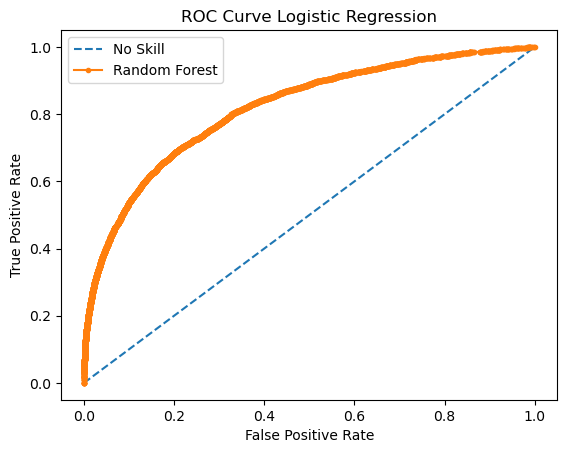

In [36]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
# Show the plot
plt.show()